# Toronto Data

This notebook documents the compilation of the Toronto datasets provided for the [Computational Essay](computational_essay).

In [1]:
import pandas
import geopandas
import contextily

## Toronto Neighbourhoods

### Geometries

Neighbourhood geometries are available from the Toronto Open Data portal ([URL](https://open.toronto.ca/dataset/neighbourhoods/)).

In [2]:
url = ("https://ckan0.cf.opendata.inter.prod-toronto.ca/"\
       "download_resource/a083c865-6d60-4d1d-b6c6-b0c8a85f9c15"\
       "?format=geojson&projection=4326")

geoms = geopandas.read_file(url)
url

'https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/a083c865-6d60-4d1d-b6c6-b0c8a85f9c15?format=geojson&projection=4326'

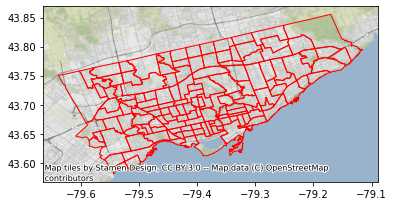

In [3]:
ax = geoms.plot(facecolor="none", edgecolor="red")
contextily.add_basemap(ax, crs=geoms.crs)

### Socio-economic characteristics

Also from the Toronto Open Data Portal, we use the [Neighbourhood Profiles](https://open.toronto.ca/dataset/neighbourhood-profiles/) data product.

In [4]:
url = ("https://ckan0.cf.opendata.inter.prod-toronto.ca/"\
       "download_resource/ef0239b1-832b-4d0b-a1f3-4153e53b189e"\
       "?format=csv")
np_all = pandas.read_csv(url)
url

'https://ckan0.cf.opendata.inter.prod-toronto.ca/download_resource/ef0239b1-832b-4d0b-a1f3-4153e53b189e?format=csv'

After inspection, we subset the following variables:

In [5]:
vars_to_keep = {
    3: "population2016", 
    8: "population_sqkm", 
    10: "pop_0-14_yearsold", 
    11: "pop_15-24_yearsold", 
    12: "pop_25-54_yearsold", 
    13: "pop_55-64_yearsold", 
    14: "pop_65+_yearsold", 
    15: "pop_85+_yearsold", 
    1018: "hh_median_income2015", 
    1149: "canadian_citizens", 
    1711: "deg_bachelor", 
    1713: "deg_medics", 
    1714: "deg_phd", 
    1887: "employed", 
    1636: "bedrooms_0", 
    1637: "bedrooms_1", 
    1638: "bedrooms_2", 
    1639: "bedrooms_3", 
    1641: "bedrooms_4+", 
}

In [6]:
np = np_all.set_index("_id").loc[vars_to_keep.keys(), :]           

meta = np.assign(name=pandas.Series(vars_to_keep))\
         .reset_index()[["_id",
                         "name", 
                         "Category", 
                         "Topic", 
                         "Data Source", 
                         "Characteristic"
                        ]]

np_renamed = np.loc[:, "Agincourt North":]\
               .T\
               .rename(columns=vars_to_keep)\
               .reset_index()\
               .rename(columns={"index": "neighbourhood_name"})

### Consolidation

In [7]:
name_parser = lambda s: " ".join(s.split(" ")[:-1])\
                           .replace("St.James", "St. James")\
                           .replace("Pellam", "Pelham")
numerify = lambda s: float(s.replace(",", ""))
db = geoms.loc[:, ["_id", "AREA_NAME", "Shape__Area", "geometry"]]\
          .assign(neighbourhood_name=geoms["AREA_NAME"].apply(name_parser))\
          .join(np_renamed.set_index("neighbourhood_name"), on="neighbourhood_name")
db.loc[:, "population2016":] = db.loc[:, "population2016":].apply(lambda s: s.map(numerify))
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   _id                   140 non-null    int64   
 1   AREA_NAME             140 non-null    object  
 2   Shape__Area           140 non-null    float64 
 3   geometry              140 non-null    geometry
 4   neighbourhood_name    140 non-null    object  
 5   population2016        140 non-null    float64 
 6   population_sqkm       140 non-null    float64 
 7   pop_0-14_yearsold     140 non-null    float64 
 8   pop_15-24_yearsold    140 non-null    float64 
 9   pop_25-54_yearsold    140 non-null    float64 
 10  pop_55-64_yearsold    140 non-null    float64 
 11  pop_65+_yearsold      140 non-null    float64 
 12  pop_85+_yearsold      140 non-null    float64 
 13  hh_median_income2015  140 non-null    float64 
 14  canadian_citizens     140 non-null    float64 
 15

### Write out

In [8]:
! rm -f toronto_socio-economic.gpkg toronto_socio-economic_vars.csv
db.to_file("toronto_socio-economic.gpkg", driver="GPKG")
meta.to_csv("toronto_socio-economic_vars.csv", index=False)

## Toronto Yahoo images

This is a subsample of the [100 million Yahoo dataset](http://projects.dfki.uni-kl.de/yfcc100m/) for the Toronto bounding box.

**NOTE** - The code below requires the dataset to be chunked in parquet files, and available to the notebook.

```python
import dask.dataframe as dd
from numpy.random import seed
```

Bounding box coordinates:

```python
w, s, e, n = -79.63926493,  43.580996  , -79.1154515 ,  43.85545719
```

Connect to dataset:

```python
db = dd.read_parquet("yfcc_chunk_*.parquet")
```

Query to extract Toronto:

```python
tnt = db.loc[(db["longitude"] > w) & \
             (db["longitude"] < e) & \
             (db["latitude"] < n) & \
             (db["latitude"] > s),
            :]
```

Computation to extract Toronto:

```python
sample = tnt.compute()
```

This contains almost a quarter of a million images, so we pick a random subset of 2,000:

```python
seed(1234)
subsample = sample.sample(2000)
```

Write it out to a `.csv` file:

```python
subsample.to_csv("toronto_flickr_subset.csv")
```

## Download links

- {download}`[Download the socio-economic dataset for Toronto as a GeoPackage] <toronto_socio-economic.gpkg>`
- {download}`[Download variable information for the socio-economic dataset of Toronto as a csv] <toronto_socio-economic_vars.csv>`
- {download}`[Download the Flickr dataset for Toronto as a csv] <toronto_flickr_subset.csv>`